## Packages Required

In [77]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import sklearn
import matplotlib.pyplot as plt

# SVI Parameterisation

### SVI Class - Deprecated

In [375]:
class SVI():
    def __init__(self, a, b, rho, sig, m):
        self.volData = volData
        self.a = a
        self.m = m
        self.b = b
        self.rho = rho
        self.sig = sig

    def SVI_raw(self, volData, a, b, m, rho, sig):
        self.daysExp = volData[0,:]/365
        self.strike = volData[1,:]
        totalVol = a + b * (
            rho * (self.strike - m) + np.sqrt((self.strike - m) ** 2) + sig **2)
        impliedVol = totalVol / self.daysExp
        return impliedVol
    
    def SVI_JW(self, volData):
        self.daysExp = volData[0,:]/365
        self.strike = volData[1,:]
        # raw Parameters
        a = self.a
        b = self.b
        rho = self.rho
        m = self.m
        sig = self.sig
        t = self.daysExp
        
        # SVI Jump-Wings
        wt = (self.a + self.b * ( - self.rho * m + np.sqrt(self.m ** 2 + self.sig ** 2)))
        vt = wt / (t)
        phit = (1 / np.sqrt(wt)) * self.b / 2 * ( - self.m / np.sqrt(self.m ** 2 + self.sig ** 2) + self.rho)
        pt = 1 / np.sqrt(wt) * self.b * (1 - self.rho)
        ct = 1 / np.sqrt(wt) * self.b * ( 1+ self.rho)
        vTilde = (self.a + self.b * self.sig * np.sqrt(1 - self.rho ** 2)) / (t)
        
        # Parameterisation
        beta = self.rho - 2 * phit * np.sqrt(wt) / self.b
        alpha = np.sign(beta) * np.sqrt(1/(beta ** 2) - 1)
        
        bNew = np.sqrt(wt) / 2 * (ct + pt)
        rhoNew = 1 - pt * np.sqrt(wt)/b
        mNew = ((vt - vTilde) * t)/(b *(
            - rho + np.sign(alpha) * np.sqrt(1 + alpha ** 2) - alpha * np.sqrt(1 - rho ** 2)))
        aNew = vTilde * t - b * sig * np.sqrt(1 - rho)        
        if m == 0:
            sigNew = (vt * t - a)/b
        else:
            sigNew = alpha * m
            
        impliedVol = self.SVI_raw(a = aNew, b = bNew, m = mNew, rho = rhoNew, sig = sigNew)
        
        return impliedVol
        

        

### SVI Functions - Used in fitting IV surface

In [612]:
def SVI_raw(volData, a, b, m, rho, sig):
        daysExp = volData[0,:]
        strike = volData[1,:]
        totalVol = a + b * (
            rho * (strike - m) + np.sqrt((strike - m) ** 2 + sig **2))
        impliedVol = np.sqrt(totalVol / daysExp)
        return impliedVol
    
def SVI_JW(volData, a, b, m, rho, sig):
        daysExp = volData[0,:]
        strike = volData[1,:]
        t = daysExp
        
        # SVI Jump-Wings
        wt = (a + b * ( - rho * m + np.sqrt(m ** 2 + sig ** 2)))
        vt = wt / (t)
        phit = (1 / np.sqrt(wt)) * b / 2 * ( - m / np.sqrt(m ** 2 + sig ** 2) + rho)
        pt = 1 / np.sqrt(wt) * b * (1 - rho)
        ct = 1 / np.sqrt(wt) * b * ( 1+ rho)
        vTilde = (a + b * sig * np.sqrt(1 - rho ** 2)) / (t)
        
        # Parameterisation
        beta = rho - 2 * phit * np.sqrt(wt) / b
        alpha = np.sign(beta) * np.sqrt(1/(beta ** 2) - 1)
        
        bNew = np.sqrt(wt) / 2 * (ct + pt)
        rhoNew = 1 - pt * np.sqrt(wt)/b
        mNew = ((vt - vTilde) * t)/(b *(
            - rho + np.sign(alpha) * np.sqrt(1 + alpha ** 2) - alpha * np.sqrt(1 - rho ** 2)))
        aNew = vTilde * t - b * sig * np.sqrt(1 - rho)        
        if m == 0:
            sigNew = (vt * t - a)/b
        else:
            sigNew = alpha * m
            
        impliedVol = SVI_raw(volData = volData, a = aNew, b = bNew, m = mNew, rho = rhoNew, sig = sigNew)
        
        return impliedVol

## Fitting the IV Curve

We now fit the IV curve to the above SVI parameterisations. To do this we will adopt a least-squares approach, subject to constraints on the values of the parameters $a, b, m,$ $\rho$ and $\sigma$ as determined in the Galerkin paper.

In [4]:
priceData = np.load('joinData.pkl', allow_pickle = True)

In [620]:
allData = priceData.loc['2015-01-01':'2016-01-01']
allData = allData[(allData.moneyness > 0.6) & (allData.moneyness < 1.2)]
numDates = allData.index.unique().size

In [621]:
SVIparameters = np.zeros((numDates, 5))
initVal = [0.4,0.1,0.1,-0.5,0.1]
bnds = ((None, None), (0.0001, None), (None, None), (-0.9999, 0.9999), (0.0001, None))

for i in range(numDates):
    dateData = allData.loc[allData.index.unique()[i]]
    dateData = dateData[dateData.daysExp.isin(dateData.daysExp.unique()[0:5])]

    yData = dateData.filter(['IV'])
    yData = np.array(yData).T[0]

    xData = dateData.filter(['daysExp', 'strike'])
    xData = np.array(xData).T
    
    def nonLinConstraintFun(x):
        return (x[0] + x[1] * x[4] * np.sqrt(1 - x[3] **2))

    nonLinearConstraint = opt.NonlinearConstraint(nonLinConstraintFun, 0, np.inf)
    
    cons = ({'type' : 'ineq', 'fun' : nonLinConstraint})
        
    ## Least Squares Minimisation
    funcToMin = lambda x: sum((SVI_raw(xData, x[0], x[1], x[2], x[3], x[4]) - yData)**2)
    fittedValues = opt.minimize(funcToMin, initVal, constraints = [nonLinearConstraint], bounds = bnds,
                                method = 'SLSQP', options={'maxiter':10000})
    SVIparameters[i,:] = fittedValues.x

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / 

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / 

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / 

/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds du

/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)
/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds du

We fit the curve via Least Squares with linear and non-linear contraints on the parameters.


In [622]:
dateData = allData.loc[allData.index.unique()[0]]
dateData = dateData[dateData.daysExp.isin(dateData.daysExp.unique()[0:5])]

yData = dateData.filter(['IV'])
yData = np.array(yData).T[0]

xData = dateData.filter(['daysExp', 'moneyness'])
xData = np.array(xData).T

## Fit Check
Here we test the fit of the SVI on a slice of the IV surface on a certain day in the training data.

In [623]:
# Constraints
def nonLinConstraintFun(x):
    return (x[0] + x[1] * x[4] * np.sqrt(1 - x[3] **2))

nonLinearConstraint = opt.NonlinearConstraint(nonLinConstraintFun, 0, np.inf)
bnds = ((None, None), (0.0001, None), (None, None), (-0.999, 0.999), (0.0001, None))

#linConstraint = opt.LinearConstraint(np.eye(5),[-np.inf, 0, -np.inf, -0.9999, 0.00001],
                               #      [np.inf, np.inf, np.inf, 0.9999, np.inf])

## Initial Values
initVal = [0.4,0.5,0.5,0.5,0.5]
cons = ({'type' : 'ineq', 'fun' : nonLinConstraint})
        
## Least Squares Minimisation
funcToMin = lambda x: sum((SVI_raw(xData, x[0], x[1], x[2], x[3], x[4]) - yData)**2)
fittedValues = opt.minimize(funcToMin, initVal, constraints = [nonLinearConstraint], bounds = bnds,
                            method = 'SLSQP', options={'maxiter':10000})


/opt/anaconda3/envs/AQFseminar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/qz/tbpst7xn3vx136h1lxlk2xhc0000gn/T/ipykernel_66297/3964179472.py:6: RuntimeWarning: invalid value encountered in sqrt
  impliedVol = np.sqrt(totalVol / daysExp)


Now that we have parameterised the SVI for this date, we will show the fit of the curve for a single days to maturity.

In [624]:
testSet = dateData[dateData['daysExp'] == dateData.daysExp.unique()[0]]

In [625]:
[low, high] = [np.min(testSet.moneyness), np.max(testSet.moneyness)]
strikeAxis = np.linspace(low, high, 1000).T
timeValue = np.ones(1000) * dateData.daysExp.unique()[0]
xDataTest = np.stack([timeValue, strikeAxis])
[a, b, m, rho, sig] = fittedValues.x
fittedCurve = SVI_raw(xDataTest, a, b, m, rho, sig) 

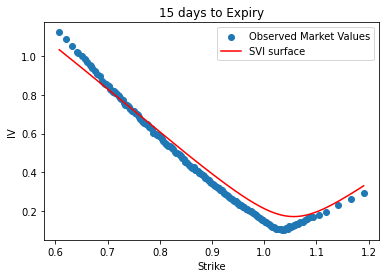

In [626]:
plt.scatter(testSet.moneyness, testSet.IV)
plt.plot(strikeAxis, fittedCurve, 'r-')
plt.title('15 days to Expiry')
plt.xlabel('Strike')
plt.ylabel('IV')
plt.legend(['Observed Market Values','SVI surface'])

As observed above, the volatility smirk is clear. The SVI approximates the surface well for OTM options, but slightly overestimates volatility in and around the money. As usual, the in-the-money section of the surface is sparse in data.

# Creating the Standardised IV Surface 

This IV surface will be standardised at set time to expiry and (normalised) strike prices.